In [1]:
"""
NOTE: you should do the following:
1. Have conda
2. `conda env create -n dl-pset3 python=3.12`
3. `conda activate dl-pset3`
4. `pip install -r requirements_pset3.txt`
5. From a terminal that is IN THAT CONDA ENV, run `jupyter notebook` (ideally using screen or tmux)
6. Connect via the URL it tells you using vscode or whatever. Then you can run this with all the dependencies.
"""

'\nNOTE: you should do the following:\n1. Have conda\n2. `conda env create -n dl-pset3 python=3.12`\n3. `conda activate dl-pset3`\n4. `pip install -r requirements_pset3.txt`\n5. From a terminal that is IN THAT CONDA ENV, run `jupyter notebook` (ideally using screen or tmux)\n6. Connect via the URL it tells you using vscode or whatever. Then you can run this with all the dependencies.\n'

In [2]:
import torch
import torch.nn as nn
from typing import Tuple, Union, Optional, List
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import einops
import subprocess
import random
import re
from jaxtyping import Float, Int, Bool
from typing import Dict, List, Optional, Any, Union, Tuple, Callable, Iterator, Iterable

In [3]:
"""
Add a script to be able to fetch the proper device for GPU. We run this sometimes
on our own machines and there could be people sharing and we need to use different GPUs.
"""
def get_gpu_info():
    try:
        # Run nvidia-smi command
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, text=True)
        output = result.stdout

        # Parse the output
        gpu_info = []
        memory_usage = re.findall(r'(\d+)MiB\s+/\s+(\d+)MiB', output)
        processes = re.findall(r'\|\s+(\d+)\s+N/A\s+N/A\s+(\d+)', output)

        for i, (used, total) in enumerate(memory_usage):
            available = int(total) - int(used)
            has_process = any(int(gpu_id) == i for gpu_id, _ in processes)
            gpu_info.append({
                'gpu_id': i,
                'available_memory': available,
                'has_process': has_process
            })

        return gpu_info
    except subprocess.CalledProcessError:
        print("Error: Unable to run nvidia-smi. Make sure it's installed and in your PATH.")
        return None

def get_available_device(
    as_string: bool = False,
    index: Optional[int] = None,
    memory_needed_mb: int = 15_000,
    in_use_ok: bool = True,
    mps_osx_ok: bool = False,
    randomize: bool = False,
    preferred_indices: List[int] | int = [],
    only_these_indices: Optional[List[int]] | int = None,
) -> Union[torch.device, str]:
    if index is not None:
        return torch.device(f"cuda:{index}") if not as_string else f"cuda:{index}"
    # Otherwise, find the best index to use!
    try:
        gpus = get_gpu_info()
    except:
        gpus = []
    gpus = [] if gpus is None else gpus
    gpus = [
        gpu
        for gpu in gpus
        if gpu["available_memory"] > memory_needed_mb
        and (in_use_ok or not gpu["in_use"])
    ]
    if len(gpus) == 0:
        if mps_osx_ok and torch.backends.mps.is_available():
            return torch.device("mps")
        return torch.device("cpu")
    # filter our preferred indices
    if only_these_indices is not None:
        only_these_indices = [only_these_indices] if isinstance(only_these_indices, int) else only_these_indices
        gpus = [gpu for gpu in gpus if gpu["gpu_id"] in only_these_indices]
    # get da biggest boi
    gpus = sorted(gpus, key=lambda x: x["available_memory"], reverse=True)
    # sort our priority ones into first spot if possible
    # NOTE: https://docs.python.org/3/howto/sorting.html (sorts are guaranteed to be
    # stable)
    preferred_indices = [preferred_indices] if isinstance(preferred_indices, int) else preferred_indices
    gpu2priority: Dict[int, int] = {
        g["gpu_id"]: (0 if g["gpu_id"] in preferred_indices else 1) for g in gpus
    }
    gpus = sorted(gpus, key=lambda x: gpu2priority[x["gpu_id"]], reverse=False)
    # randomly select one of these guys
    selector_index = random.randint(0, len(gpus) - 1) if randomize else 0
    gpu_index = gpus[selector_index]["gpu_id"]
    return torch.device(f"cuda:{gpu_index}") if not as_string else f"cuda:{gpu_index}"

device = get_available_device(memory_needed_mb=80_000, as_string=True) # paranoid: use 55GB from A100 style GPU
print("Found device: ", device)

Found device:  cuda:1


In [4]:
# a utility for calculating running average
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

# Problem 2: Implement a Transformer

## Part 2.A

In [5]:
class AttentionHead(nn.Module):
    """ Single head attention. """
    def __init__(self, dim: int, n_hidden: int):
        # dim: the dimension of the input
        # n_hidden: the dimension of the keys, queries, and values

        super().__init__()

        self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
        self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
        self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
        self.n_hidden = n_hidden

    def forward(
            self,
            x: Float[torch.Tensor, "batch seq dim"],
            attn_mask: Optional[Float[torch.Tensor, "batch seq_q seq_k"]]
        ) -> Tuple[Float[torch.Tensor, "batch seq dim"], Float[torch.Tensor, "batch seq_q seq_k"]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
        # alpha            the attention weights (after softmax). shape: (B x T x T)
        #

        out, alpha = None, None
        #  Compute self attention on x.
        #       (1) First project x to the query Q, key K, value V.
        #       (2) Then compute the attention weights alpha as:
        #                  alpha = softmax(QK^T/sqrt(n_hidden))
        #           Make sure to take into account attn_mask such that token i does not attend on token
        #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
        #           to before the softmax so that after the softmax the value is 0?)
        #       (3) The output is a linear combination of the values (weighted by the alphas):
        #                  out = alpha V
        #       (4) return the output and the alpha after the softmax

        # ======= Answer START ========
        keys = self.W_K(x)
        queries = self.W_Q(x)
        values = self.W_V(x)
        normalizer = torch.sqrt(torch.tensor(self.n_hidden, dtype=torch.float32))
        assert len(normalizer.shape) == 0 or normalizer.shape == (1,), f"normalizer has wrong shape: {normalizer.shape}"
        table = einops.einsum(queries, keys, "batch seq1 kq_dim, batch seq2 kq_dim -> batch seq1 seq2") / normalizer
        if attn_mask is not None:
            table = table.masked_fill(attn_mask == 0, -float('inf')) 
        alpha = torch.softmax(table, dim=-1) # the attending amounts
        out = alpha @ values # "z" acc. to transformer lens etc...
        # ======= Answer  END ========
        assert out is not None
        assert alpha is not None

        assert out.shape == x.shape

        return out, alpha


## Part 2.B

In [103]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimenstion for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # DONE: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)

        # ======= Answer START ========
        # Just do it by using one big matrix for K, Q, V
        self.W_K = nn.Linear(dim, n_hidden * num_heads)
        self.W_Q = nn.Linear(dim, n_hidden * num_heads)
        self.W_V = nn.Linear(dim, n_hidden * num_heads)
        self.W_O = nn.Linear(n_hidden * num_heads, dim)
        self.n_hidden = n_hidden
        self.num_heads = num_heads

        # ======= Answer  END ========

    def forward(
            self,
            x: Float[torch.Tensor, "batch seq dim"],
            attn_mask: Optional[Float[torch.Tensor, "batch seq_q seq_k"]]
        ) -> Tuple[Float[torch.Tensor, "batch seq dim"], Float[torch.Tensor, "batch head seq_q seq_k"]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_output, attn_alphas = None, None

        # Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.

        # ======= Answer START ========
        # batch calculate the keys, queries, values
        keys_concatted = self.W_K(x)
        queries_concatted = self.W_Q(x)
        values_concatted = self.W_V(x)

        # get the per-head values
        keys = einops.rearrange(keys_concatted, "batch seq (n_heads n_hidden) -> batch n_heads seq n_hidden", n_heads=self.num_heads, n_hidden=self.n_hidden)
        queries = einops.rearrange(queries_concatted, "batch seq (n_heads n_hidden) -> batch n_heads seq n_hidden", n_heads=self.num_heads, n_hidden=self.n_hidden)
        values = einops.rearrange(values_concatted, "batch seq (n_heads n_hidden) -> batch n_heads seq n_hidden", n_heads=self.num_heads, n_hidden=self.n_hidden)
        
        # calculate the attention amounts PER head seperately
        normalizer = torch.sqrt(torch.tensor(self.n_hidden, dtype=torch.float32))
        assert len(normalizer.shape) == 0 or normalizer.shape == (1,), f"normalizer has wrong shape: {normalizer.shape}"
        tables = einops.einsum(queries, keys, "batch n_heads seq_q n_hidden, batch n_heads seq_k n_hidden -> batch n_heads seq_q seq_k") / normalizer
        if attn_mask is not None:
            # NOTE: dimension broadcasting won't work because the last indices won't match so you
            # need to repeat to get the right shape
            attn_mask = einops.repeat(attn_mask, "batch seq_q seq_k -> batch n_heads seq_q seq_k", n_heads=self.num_heads)
            # asset for DEBUG when you need; note that this supports broadcasting
            # assert tables.shape == attn_mask.shape, f"attention mask and tables have different shapes: {tables.shape} != {attn_mask.shape}"
            tables = tables.masked_fill(attn_mask == 0, -float('inf'))
        
        # calculate the attention SCOREs (after softmax: z)
        alphas = torch.softmax(tables, dim=-1)
        attn_alphas = alphas

        # z is you matmul independently per head, then concatenate the results to get z_catted 
        # NOTE: each query pulls in the value corresponding to the linear combination it gets, which is over the keys
        z = einops.einsum(alphas, values, "batch n_heads seq_q seq_k, batch n_heads seq_k n_hidden -> batch n_heads seq_q n_hidden")
        z_concatted = einops.rearrange(z, "batch n_heads seq_q n_hidden -> batch seq_q (n_heads n_hidden)", n_heads=self.num_heads, n_hidden=self.n_hidden)
        attn_output = self.W_O(z_concatted)

        # ======= Answer END ========
        assert attn_output is not None
        assert attn_alphas is not None

        assert attn_output.shape == x.shape

        return attn_output, attn_alphas

## Part 2.C

In [7]:
# these are already implemented for you!

class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim       the dimension of the input
        # n_hidden  the width of the linear layer

        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: Float[torch.Tensor, "batch seq dim"])-> Float[torch.Tensor, "batch seq dim"]:
        # x         the input. shape: (B x T x dim)

        # Outputs:
        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)

class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        super().__init__()
        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)
        self.ffn = FFN(dim, mlp_dim)

    def forward(
            self,
            x: Float[torch.Tensor, "batch seq dim"],
            attn_mask: Float[torch.Tensor, "batch seq_q seq_k"]
        ) -> Tuple[Float[torch.Tensor, "batch seq dim"], Float[torch.Tensor, "batch head seq_q seq_k"]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_out, alphas = self.attn(x=x, attn_mask=attn_mask)
        x = attn_out + x
        x = self.ffn(x) + x
        return x, alphas

In [8]:
class Transformer(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.

        # ======= Answer START ========
        self.layers = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads) for _ in range(num_layers)])
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dim = dim
        self.attn_dim = attn_dim
        self.mlp_dim = mlp_dim

    def forward(
            self,
            x: Float[torch.Tensor, "batch seq dim"],
            attn_mask: Float[torch.Tensor, "batch seq seq"],
            return_attn: bool = False
        ) -> Tuple[Float[torch.Tensor, "batch seq dim"], Optional[Float[torch.Tensor, "batch layer head seq_q seq_k"]]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)
        # NOTE: slight device bug in their testing code, need smae device; do it transformer and not below
        # so that we are not running the risk of bad perf.
        _device = next(self.parameters()).device
        if x.device != _device:
            x = x.to(_device)
        if attn_mask is not None and attn_mask.device != x.device:
            attn_mask = attn_mask.to(x.device)

        output, collected_attns = None, None

        # Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        # NOTE: we should use jaxtyping?!
        # NOTE: we should actually wrap everything for better hooks usage
        residual_stream: Float[torch.Tensor, "batch seq dim"] = x
        collected_attns: List[Float[torch.Tensor, "batch layer head seq_q seq_k"]] = []
        for layer in self.layers:
            residual_stream, alphas = layer(residual_stream, attn_mask)
            if return_attn:
                collected_attns.append(alphas)
        output = residual_stream
        # ======= Answer END ========
        assert output is not None
        assert collected_attns is not None

        attn_alphas: Optional[Float[torch.Tensor, "batch layer head seq_q seq_k"]] = None
        if return_attn:
            attn_alphas = torch.stack(collected_attns, dim=0)
            attn_alphas = einops.rearrange(
                attn_alphas,
                "layer batch head seq_q seq_k -> batch layer head seq_q seq_k",
                layer=self.num_layers,
                head=self.num_heads,
                batch=x.shape[0],
                seq_q=x.shape[1],
                seq_k=x.shape[1]
            )
        return output, attn_alphas


Test your transformer implementation here

In [9]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers).to(device)

    inp = torch.randn(batch_size, num_tokens, dim).to(device)

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        assert alpha is None
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"
        assert alpha.shape == (batch_size, num_layers, num_heads, num_tokens, num_tokens), f"wrong alpha shape {alpha.shape}"

    print("Test Case 3")
    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).to(device)
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
        print("Attention mask pattern", attn_mask[0])
        print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

    print("Test Case 4")
    # test case 4 creates a causal mask where each token can only attend to previous tokens and itself
    causal_mask = torch.tril(torch.ones(num_tokens, num_tokens)).unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (B, T, T)

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=causal_mask, return_attn=True)
        # Verify the causal mask
        for b in range(batch_size):
            for l in range(num_layers):
                for h in range(num_heads):
                    attn_weights = alpha[b, l, h]  # Shape: (T, T)
                    # Positions where j > i should have zero attention weights
                    # We can create a boolean mask for j > i
                    future_mask = torch.triu(torch.ones(num_tokens, num_tokens), diagonal=1).bool()  # Shape: (T, T)
                    # Extract attention weights for future positions
                    future_attn = attn_weights[future_mask]
                    # Assert that these weights are close to zero
                    assert torch.all(future_attn < 1e-6), f"Causal mask violated in batch {b}, layer {l}, head {h}"

perform_transformer_test_cases()

Test Case 1
Test Case 2
Test Case 3
Attention mask pattern tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]], device='cuda:1')
Alpha pattern tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5569, 0.4431, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5716, 0.4284,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.7984, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4187, 0.5813, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.7168, 0.2832]],
       device='cuda:1')
Test Case 4


## Problem 3: Vision Transformer

## Part 3.A

In [10]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size: int, patch_size: int, nin: int, nout: int):
        # img_size       the width and height of the image. you can assume that
        #                the images will be square
        # patch_size     the width of each square patch. You can assume that
        #                img_size is divisible by patch_size
        # nin            the number of input channels
        # nout           the number of output channels

        super().__init__()
        assert img_size % patch_size == 0

        self.img_size = img_size
        self.patch_size = patch_size
        assert self.img_size % self.patch_size == 0
        self.num_patches = (img_size // patch_size)**2
        self.nin = nin
        self.nout = nout

        # DONE Set up parameters for the Patch Embedding
        # ======= Answer START ========
        self.patch_proj = nn.Linear(patch_size**2 * nin, nout)
        # ======= Answer END ========

    def forward(self, x: Float[torch.Tensor, "batch nin height width"]) -> Float[torch.Tensor, "batch num_patches nout"]:
        # x        the input image. shape: (B, nin, Height, Width)
        #
        # Output
        # out      the patch embeddings for the input. shape: (B, num_patches, nout)
        assert x.shape[1] == self.nin
        assert x.shape[2] == self.img_size
        assert x.shape[3] == self.img_size
        assert x.shape[2] % self.patch_size == 0
        assert x.shape[3] % self.patch_size == 0
        _batch_size = x.shape[0]

        _device = next(self.parameters()).device
        if x.device != _device:
            x = x.to(_device)

        # DONE: Implement the patch embedding. You want to split up the image into
        # square patches of the given patch size. Then each patch_size x patch_size
        # square should be linearly projected into an embedding of size nout.
        #
        # Hint: Take a look at nn.Conv2d. How can this be used to perform the
        #       patch embedding?
        out = None

        # ======= Answer START ========
        blocks = einops.rearrange(
            x,
            # (block_height, block_width) = number of blocks (i.e. number of tokens/patches)
            "batch nin (num_blocks_height patch_size_height) (num_blocks_width patch_size_width) -> batch (num_blocks_height num_blocks_width) (patch_size_height patch_size_width nin)",
            batch=x.shape[0],
            nin=self.nin,
            num_blocks_height=self.img_size // self.patch_size,
            num_blocks_width=self.img_size // self.patch_size,
            patch_size_height=self.patch_size,
            patch_size_width=self.patch_size
        )
        assert blocks.shape == (_batch_size, self.num_patches, self.patch_size**2 * self.nin), f"wrong blocks shape {blocks.shape}, should be {(_batch_size, self.num_patches, self.patch_size**2 * self.nin)}"
        out = self.patch_proj(blocks)
        # ======= Answer END ========
        assert out.shape == (_batch_size, self.num_patches, self.nout), f"wrong output shape {out.shape}, should be {(_batch_size, self.num_patches, self.nout)}"
        return out

def test_patch_embed_shape():
    patch_embed = PatchEmbed(img_size=32, patch_size=4, nin=3, nout=64)
    test_input = torch.randn(5, 3, 32, 32)
    out = patch_embed(test_input)
    print(out.shape)
    assert out.shape == (5, 64, 64) # batch x seq x dim

test_patch_embed_shape()
print(device)

torch.Size([5, 64, 64])
cuda:1


## Part 3.B

In [11]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        n_channels: int,
        nout: int,
        img_size: int,
        patch_size: int,
        dim: int,
        attn_dim: int,
        mlp_dim: int,
        num_heads: int,
        num_layers: int
    ):
        # n_channels       number of input image channels
        # nout             desired output dimension
        # img_size         width of the square image
        # patch_size       width of the square patch
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, nin=n_channels, nout=dim)
        self.pos_E = nn.Embedding((img_size//patch_size)**2, dim) # positional embedding matrix

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)) # learned class embedding
        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, nout)
        )


    def forward(self, img: torch.Tensor, return_attn=False) ->Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # img          the input image. shape: (B, nin, img_size, img_size)
        # return_attn  whether to return the attention alphas
        #
        # Outputs
        # out          the output of the vision transformer. shape: (B, nout)
        # alphas       the attention weights for all heads and layers. None if return_attn is False, otherwise
        #              shape: (B, num_layers, num_heads, num_patches + 1, num_patches + 1)
        # NOTE: again they didn't use the right device
        _device = next(self.parameters()).device
        if img.device != _device:
            img = img.to(_device)

        # generate embeddings
        embs = self.patch_embed(img) # patch embedding
        B, T, _ = embs.shape
        pos_ids = torch.arange(T).expand(B, -1).to(embs.device)
        embs += self.pos_E(pos_ids) # positional embedding

        cls_token = self.cls_token.expand(len(embs), -1, -1)
        x = torch.cat([cls_token, embs], dim=1)

        x, alphas = self.transformer(x, attn_mask=None, return_attn=return_attn)
        out = self.head(x)[:, 0]
        assert len(x.shape) == 3 # batch x seq x dim
        return out, alphas


def test_vision_transformer_shape():
    vit = VisionTransformer(
        n_channels=3,
        nout=10, # 10 classes
        img_size=32,
        patch_size=4,
        dim=512,
        attn_dim=255,
        mlp_dim=33,
        num_heads=16,
        num_layers=4
    )
    test_input = torch.randn(7, 3, 32, 32)
    out, alphas = vit(test_input, return_attn=True)
    print(out.shape, alphas.shape)
    assert out.shape == (7, 10)
    # 12 
    # NOTE how they append the cls token above (or prepend?)
    assert alphas.shape == (7, 4, 16, 64 + 1, 64 + 1), f"{alphas.shape}" # batch layer n_heads seq + 1 seq + 1
test_vision_transformer_shape()


torch.Size([7, 10]) torch.Size([7, 4, 16, 65, 65])


## Part 3.C

In [12]:
# # set up the dataset and dataloader

MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])
inv_transform = transforms.Compose([
    transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1/np.array(STD)),
    transforms.Normalize(
        mean = -np.array(MEAN),
        std = [ 1., 1., 1. ]),
    transforms.ToPILImage(),
])


# train_dataset = torchvision.datasets.CIFAR10(train=True, root='data', transform=img_transform, download=True)
# val_dataset = torchvision.datasets.CIFAR10(train=False, root='data', transform=img_transform)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16000, shuffle=True, num_workers=10)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16000, shuffle=False, num_workers=10)
train_dataset = torchvision.datasets.CIFAR10(train=True, root='data', transform=img_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(train=False, root='data', transform=img_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=10)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=10)

Files already downloaded and verified


In [13]:
# set up the model and optimizer

import torch.optim as optim
from pathlib import Path

# Model it to be roughly the same size as GPT-2 divided by 1.5 ish
model = VisionTransformer(
    n_channels=3,
    nout=10,
    img_size=32,
    patch_size=4,
    dim=128,
    attn_dim=64,
    mlp_dim=128,
    num_heads=3,
    num_layers=6,
).cuda()

# Should load from checkpoint if we want to continue training from there
# We should load the annealing, etc... scheduler but whatever :P
load_from: Optional[Path] = (
    None  # Path("/mnt/align3_drive/adrianoh/dl_pset_3/after_epoch_10.pt")
)
STARTING_EPOCH: int = 0  # 11
if load_from is not None:
    model.load_state_dict(torch.load(load_from))
model = model.to(device)

criterion = nn.CrossEntropyLoss()


NUM_EPOCHS = 60
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [14]:
# evaluate the model
def evaluate_cifar_model(model, criterion, val_loader):
    is_train = model.training
    model.eval()
    with torch.no_grad():
        loss_meter, acc_meter = AverageMeter(), AverageMeter()
        for img, labels in val_loader:
            # move all img, labels to device (cuda)
            img = img.to(device)
            labels = labels.to(device)
            outputs, _ = model(img)
            loss_meter.update(criterion(outputs, labels).item(), len(img))
            acc = (outputs.argmax(-1) == labels).float().mean().item()
            acc_meter.update(acc, len(img))
    model.train(is_train)
    return loss_meter.calculate(), acc_meter.calculate()

In [15]:
# Time Estimate: less than 5 minutes on T4 GPU
# train the model
from pathlib import Path
save_to_dir = Path("/mnt/align3_drive/adrianoh/dl_pset_3")
if not save_to_dir.exists():
    save_to_dir.mkdir(parents=True)
save_to_dir_q: bool = False # CHANGE THIS: when you need to debug or whatever

import tqdm
for epoch in range(STARTING_EPOCH, NUM_EPOCHS):  #
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for img, labels in tqdm.tqdm(train_dataloader):
        img, labels = img.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), len(img))
        acc = (outputs.argmax(-1) == labels).float().mean().item()
        acc_meter.update(acc, len(img))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate()}, Acc: {acc_meter.calculate()}")
    if epoch % 10 == 0:
        val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
        print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
        if save_to_dir_q:
            _state_dict = model.state_dict()
            # put everything on cpu first
            _state_dict = {k: v.cpu() for k, v in _state_dict.items()}
            file = save_to_dir / f"after_epoch_{epoch}.pt"
            if file.exists():
                raise ValueError(f"File {file.as_posix()} already exists")
            torch.save(_state_dict, file)
            print("JUST SAVED: ", file.as_posix())

val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print('Finished Training')

100%|██████████| 196/196 [00:03<00:00, 54.97it/s]

Train Epoch: 0, Loss: 1.6627851202774049, Acc: 0.39515999999046325


Val Epoch: 0, Loss: 1.4506362649917603, Acc: 0.4759


100%|██████████| 196/196 [00:03<00:00, 55.37it/s]


Train Epoch: 1, Loss: 1.3568383544158935, Acc: 0.5131000000190735


100%|██████████| 196/196 [00:04<00:00, 40.46it/s]


Train Epoch: 2, Loss: 1.242759259033203, Acc: 0.55436


100%|██████████| 196/196 [00:03<00:00, 53.60it/s]


Train Epoch: 3, Loss: 1.1496752125930787, Acc: 0.5904800000381469


100%|██████████| 196/196 [00:04<00:00, 42.02it/s]


Train Epoch: 4, Loss: 1.0850616510009765, Acc: 0.613840000038147


100%|██████████| 196/196 [00:03<00:00, 54.70it/s]


Train Epoch: 5, Loss: 1.0263255387496948, Acc: 0.6340000000190735


100%|██████████| 196/196 [00:03<00:00, 55.05it/s]


Train Epoch: 6, Loss: 0.9542997205352783, Acc: 0.6616200000572204


100%|██████████| 196/196 [00:03<00:00, 55.40it/s]


Train Epoch: 7, Loss: 0.8975853736877442, Acc: 0.6771800000381469


100%|██████████| 196/196 [00:03<00:00, 59.41it/s]


Train Epoch: 8, Loss: 0.8398071804618835, Acc: 0.7002800000190735


100%|██████████| 196/196 [00:03<00:00, 56.28it/s]


Train Epoch: 9, Loss: 0.7742897876167297, Acc: 0.7259200000190735


100%|██████████| 196/196 [00:03<00:00, 55.14it/s]

Train Epoch: 10, Loss: 0.7238838541030884, Acc: 0.7413199999809265


Val Epoch: 10, Loss: 1.2220892442703246, Acc: 0.5951


100%|██████████| 196/196 [00:04<00:00, 45.97it/s]


Train Epoch: 11, Loss: 0.6629407996368408, Acc: 0.7640999999809265


100%|██████████| 196/196 [00:03<00:00, 53.45it/s]


Train Epoch: 12, Loss: 0.6103262040138244, Acc: 0.7833599999809265


100%|██████████| 196/196 [00:03<00:00, 55.77it/s]


Train Epoch: 13, Loss: 0.5391633622360229, Acc: 0.809680000038147


100%|██████████| 196/196 [00:03<00:00, 53.24it/s]


Train Epoch: 14, Loss: 0.4972070977973938, Acc: 0.82192


100%|██████████| 196/196 [00:03<00:00, 55.69it/s]


Train Epoch: 15, Loss: 0.4357515505027771, Acc: 0.8446400000190735


100%|██████████| 196/196 [00:03<00:00, 58.34it/s]


Train Epoch: 16, Loss: 0.3842211639499664, Acc: 0.8627199999809265


100%|██████████| 196/196 [00:03<00:00, 54.57it/s]


Train Epoch: 17, Loss: 0.3446117849254608, Acc: 0.87676


100%|██████████| 196/196 [00:03<00:00, 54.28it/s]


Train Epoch: 18, Loss: 0.30529166405677793, Acc: 0.891400000038147


100%|██████████| 196/196 [00:04<00:00, 46.29it/s]


Train Epoch: 19, Loss: 0.24283156574726106, Acc: 0.91462


100%|██████████| 196/196 [00:03<00:00, 52.32it/s]

Train Epoch: 20, Loss: 0.2035765332698822, Acc: 0.9280200000190735


Val Epoch: 20, Loss: 1.7603319058418274, Acc: 0.5921


100%|██████████| 196/196 [00:03<00:00, 55.79it/s]


Train Epoch: 21, Loss: 0.19763774086475372, Acc: 0.930980000038147


100%|██████████| 196/196 [00:03<00:00, 54.27it/s]


Train Epoch: 22, Loss: 0.15764650404930114, Acc: 0.9445000000381469


100%|██████████| 196/196 [00:04<00:00, 44.92it/s]


Train Epoch: 23, Loss: 0.14188523210525514, Acc: 0.94984


100%|██████████| 196/196 [00:03<00:00, 51.96it/s]


Train Epoch: 24, Loss: 0.11912021697044373, Acc: 0.9583600000190735


100%|██████████| 196/196 [00:03<00:00, 55.25it/s]


Train Epoch: 25, Loss: 0.08589668704986572, Acc: 0.9710400000572205


100%|██████████| 196/196 [00:03<00:00, 56.08it/s]


Train Epoch: 26, Loss: 0.08496304222583771, Acc: 0.970520000038147


100%|██████████| 196/196 [00:03<00:00, 55.65it/s]


Train Epoch: 27, Loss: 0.06948978443622589, Acc: 0.975620000038147


100%|██████████| 196/196 [00:03<00:00, 55.25it/s]


Train Epoch: 28, Loss: 0.06181089623451233, Acc: 0.9784199999809265


100%|██████████| 196/196 [00:03<00:00, 57.35it/s]


Train Epoch: 29, Loss: 0.04795040121793747, Acc: 0.98426


100%|██████████| 196/196 [00:03<00:00, 56.12it/s]

Train Epoch: 30, Loss: 0.06586823683738709, Acc: 0.978


Val Epoch: 30, Loss: 2.347763451766968, Acc: 0.598


100%|██████████| 196/196 [00:03<00:00, 50.26it/s]


Train Epoch: 31, Loss: 0.04856338883519173, Acc: 0.9839


100%|██████████| 196/196 [00:03<00:00, 54.07it/s]


Train Epoch: 32, Loss: 0.02955283287525177, Acc: 0.990580000038147


100%|██████████| 196/196 [00:03<00:00, 57.42it/s]


Train Epoch: 33, Loss: 0.021404529991149904, Acc: 0.9935800000190735


100%|██████████| 196/196 [00:03<00:00, 59.41it/s]


Train Epoch: 34, Loss: 0.010732451424598694, Acc: 0.9973600000190734


100%|██████████| 196/196 [00:03<00:00, 56.15it/s]


Train Epoch: 35, Loss: 0.004582521117515862, Acc: 0.99904


100%|██████████| 196/196 [00:03<00:00, 55.94it/s]


Train Epoch: 36, Loss: 0.00117207951920107, Acc: 0.99994


100%|██████████| 196/196 [00:03<00:00, 56.05it/s]


Train Epoch: 37, Loss: 0.000534143506269902, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 56.34it/s]


Train Epoch: 38, Loss: 0.00040357044318690895, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 55.86it/s]


Train Epoch: 39, Loss: 0.0003452301647141576, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 55.03it/s]

Train Epoch: 40, Loss: 0.000306044793818146, Acc: 1.0


Val Epoch: 40, Loss: 2.793335849380493, Acc: 0.6167


100%|██████████| 196/196 [00:03<00:00, 56.57it/s]


Train Epoch: 41, Loss: 0.0002761810982879251, Acc: 1.0


100%|██████████| 196/196 [00:04<00:00, 46.58it/s]


Train Epoch: 42, Loss: 0.00025303634411655366, Acc: 1.0


100%|██████████| 196/196 [00:04<00:00, 42.54it/s]


Train Epoch: 43, Loss: 0.00023385315555147826, Acc: 1.0


100%|██████████| 196/196 [00:04<00:00, 45.91it/s]


Train Epoch: 44, Loss: 0.00021799356961622833, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 55.56it/s]


Train Epoch: 45, Loss: 0.00020461011106614023, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 55.95it/s]


Train Epoch: 46, Loss: 0.00019316830310039222, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 56.70it/s]


Train Epoch: 47, Loss: 0.00018338543522171676, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 55.69it/s]


Train Epoch: 48, Loss: 0.00017489314655773342, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 55.57it/s]


Train Epoch: 49, Loss: 0.0001676423678919673, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 54.02it/s]

Train Epoch: 50, Loss: 0.00016134691102430223, Acc: 1.0


Val Epoch: 50, Loss: 2.893204977798462, Acc: 0.6189


100%|██████████| 196/196 [00:04<00:00, 41.08it/s]


Train Epoch: 51, Loss: 0.00015602588885463774, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 56.33it/s]


Train Epoch: 52, Loss: 0.000151536345211789, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 56.01it/s]


Train Epoch: 53, Loss: 0.00014783386820927262, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 52.90it/s]


Train Epoch: 54, Loss: 0.00014484324048273265, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 56.86it/s]


Train Epoch: 55, Loss: 0.00014250625401269644, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 56.73it/s]


Train Epoch: 56, Loss: 0.00014078257288318126, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 53.81it/s]


Train Epoch: 57, Loss: 0.0001396113464003429, Acc: 1.0


100%|██████████| 196/196 [00:04<00:00, 44.41it/s]


Train Epoch: 58, Loss: 0.0001389047552458942, Acc: 1.0


100%|██████████| 196/196 [00:03<00:00, 49.00it/s]

Train Epoch: 59, Loss: 0.00013856008015573025, Acc: 1.0


Val Epoch: 59, Loss: 2.917063394546509, Acc: 0.6191
Finished Training


# Part 3.D

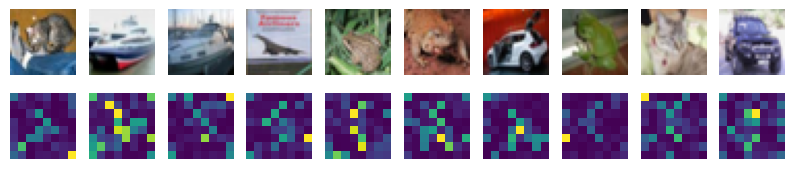

In [16]:
for val_batch in val_dataloader:
    break

model.eval()
with torch.no_grad():
    img, labels = val_batch
    img = img.to(device)
    outputs, attns = model(img, return_attn=True)

fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    # mean over layer and num heads excl the cls token, and I think they look at the cls token's attention paid to the other patches
    # excl itself.
    flattened_attns = attns.flatten(1,2)[:, :, 0, 1:].mean(1).reshape(-1, 8, 8).cpu().numpy()
    ax[0, i].imshow(inv_transform(img[i]))
    ax[1, i].imshow(flattened_attns[i])
    ax[0, i].axis(False)
    ax[1, i].axis(False)

# Problem 4: Dialogue GPT

In [28]:
import wget
import os
if not os.path.exists("input.txt"):
    wget.download("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

In [18]:
with open('input.txt', 'r') as f:
    raw_text = f.read()
all_dialogues = raw_text.split('\n\n')


In [104]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     /afs/csail.mit.edu/u/a/adrianoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /afs/csail.mit.edu/u/a/adrianoh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Part 4.A

In [130]:
def tokenize(s):
  return word_tokenize(s) # not sure why they did this?

class MyTokenizer:
    def __init__(self, raw_text: str):
        # raw_text     contains the text from which we will build our vocabulary

        self.start = '<START>' # token that starts every example
        self.pad = '<PAD>' # token used to pad examples to the same length
        self.unk = '<UNK>' # token used if encountering a word not in our vocabulary

        # NOTE: please read: https://piazza.com/class/m0pficutcic7hy/post/322
        # (basically splitting on \n\n can lead to bugs)
        tokens = []
        all_dialogues = raw_text.split('\n\n')
        for dialogue in all_dialogues:
            tokens = tokens + tokenize(dialogue)
        vocab = np.unique(tokens)
        # vocab = np.unique(tokenize(raw_text)) # <---- old code
        vocab = np.concatenate([np.array([self.start, self.pad, self.unk]), vocab])

        self.vocab: List[str] = vocab # array of tokens in order
        self.tok_to_id: Dict[str, int] = {w: i for i, w in enumerate(vocab)} # mapping of token to ID
        self.vocab_size: int = len(self.vocab) # size of vocabulary

    def encode(self, s: str, do_not_add_start_token: bool = False) -> torch.Tensor:
        # s           input string
        #
        # Output
        # id_tensor   a tensor of token ids, starting with the start token.t

        id_tensor = None

        # tokenize the input using word_tokenize. Return a tensor
        # of the token ids, starting with the token id for the start token.
        # ============ ANSWER START ===========
        id_tensor: Int[torch.Tensor, "N"] = torch.tensor([self.tok_to_id[self.start]] + [self.tok_to_id[tok] for tok in tokenize(s)])
        # ============ ANSWER END =============

        return id_tensor

    def decode(self, toks: Int[torch.Tensor, "N"]) -> str:
        # toks         a list of token ids
        #
        # Output
        # decoded_str  the token ids decoded back into a string (join with a space)

        decoded_str = None

        # convert the token ids back to the actual corresponding words.
        # Join the tokens with a space and return the full string
        # ============ ANSWER START ===========
        decoded_str = " ".join([self.vocab[tok] for tok in toks])
        # ============ ANSWER END =============
        assert decoded_str is not None

        return decoded_str

    def pad_examples(self, tok_list: List[torch.Tensor]) -> torch.Tensor:
        # Pads the tensors to the right with the pad token so that they are the same length.
        #
        # tok_list       a list of tensors containing token ids (maybe of different lengths)
        #
        # Output
        # padded_tokens  shape: (len(tok_list), max length within tok_list)
        return torch.nn.utils.rnn.pad_sequence(tok_list, batch_first=True, padding_value=self.tok_to_id[self.pad])

tok = MyTokenizer(raw_text)

In [131]:
# tokenizer test cases
input_string = 'KING RICHARD III:\nSay that I did all this for love of her.'
enc = tok.encode(input_string)
print(enc)
dec = tok.decode(enc)
print(dec)
assert dec == "<START> KING RICHARD III : Say that I did all this for love of her ."

tensor([    0,  1593,  2181,  1481,   223,  2342, 12741,  1476,  5703,  3318,
        12794,  6847,  8726,  9607,  7654,   221])
<START> KING RICHARD III : Say that I did all this for love of her .


# Part 4.B

In [132]:
class DialogueDataset:
    def __init__(self, tokenizer: MyTokenizer, lines: List[str], max_N: int):
        # tokenizer    an instance of MyTokenizer
        # lines        a list of strings. each element in an example in the dataset
        # max_N        the maximum number of tokens allowed per example. More than this will be truncated
        self.lines = lines
        self.tokenizer = tokenizer
        self.max_N = max_N

    def __len__(self) -> int:
        return len(self.lines)

    def __getitem__(self, idx: int) -> torch.Tensor:
        # returns the example at int encoded by the tokenizer
        # truncates the example if it is more than max_N tokens
        return self.tokenizer.encode(self.lines[idx])[:self.max_N]

def collate_fn(examples: List[torch.Tensor]):
    # examples        a batch of tensors containing token ids (maybe of different lengths)
    # Outputs a dictionary containing
    #   input_ids     a single tensor with all of the examples padded (from the right) to the max
    #                 length within the batch. shape:(B, max length within examples)
    #   input_mask    a tensor indicating which tokens are padding and should be ignored. 0 if padding
    #                 and 1 if not. shape: (B, max length within examples)
    new_input_ids = tok.pad_examples(examples)
    attn_mask = torch.ones(new_input_ids.shape)
    attn_mask[new_input_ids == tok.tok_to_id[tok.pad]] = 0
    return {'input_ids': tok.pad_examples(examples), 'input_mask': attn_mask}

ds = DialogueDataset(tok, all_dialogues, max_N=200)
training_dl = torch.utils.data.DataLoader(ds, batch_size=64, collate_fn=collate_fn)

In [133]:
# take a look at an example of an element from the training dataloader
for batch in training_dl:
    print(batch)
    break

{'input_ids': tensor([[   0, 1151,  708,  ...,    1,    1,    1],
        [   0,  323,  223,  ...,    1,    1,    1],
        [   0, 1151,  708,  ...,    1,    1,    1],
        ...,
        [   0, 1733,  223,  ...,    1,    1,    1],
        [   0, 1151, 2384,  ...,    1,    1,    1],
        [   0, 1733,  223,  ...,    1,    1,    1]]), 'input_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])}


## Part 4.C

In [134]:
embs = torch.ones((32, 100, 128))
B, T, _ = embs.shape
pos_ids = torch.arange(T).expand(B, -1)
print(pos_ids)
pos_E = nn.Embedding(200, 128)
print(pos_E)
pos_E(pos_ids).shape

tensor([[ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99],
        ...,
        [ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99]])
Embedding(200, 128)


torch.Size([32, 100, 128])

In [135]:
class DialogueGPT(nn.Module):
    def __init__(self, vocab_size: int, max_N: int, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # vocab_size       size of the vocabulary
        # max_N            maximum number of tokens allowed to appear in 1 example
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.

        super().__init__()

        # DONE: set up the token embedding and positional embeddings
        #       Hint, use nn.Embedding
        # ============ ANSWER START ============
        self.tok_embed = nn.Embedding(vocab_size, dim)
        self.pos_embed = nn.Embedding(max_N, dim)
        self.vocab_size = vocab_size
        self.dim = dim
        self.max_N = max_N
        self.attn_dim = attn_dim
        self.mlp_dim = mlp_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        # Register buffer so it is known to be put on the same device
        # make a buffer
        causal_attn_mask = torch.tril(torch.ones(max_N, max_N))
        assert causal_attn_mask.shape == (max_N, max_N)
        # sanity check
        assert causal_attn_mask[0, 0] == 1 # lower triangle top left vertex
        assert causal_attn_mask[-1, -1] == 1 # lower triangle bottom right vertex
        assert causal_attn_mask[0, -1] == 0 # MATRIX top right vertex shold NOT be 1
        assert causal_attn_mask[-1, 0] == 1 # lower triangle bottom left vertex
        _test_indices = torch.randint(low=0, high=max_N, size=(2, 200)) # testing 200 random pairs
        assert _test_indices.shape == (2, 200)
        # large y (top to bottom) means it should be 1 else zero; sanity checker
        _test_mask = causal_attn_mask[_test_indices[0], _test_indices[1]]
        _test_loc = _test_indices[0] >= _test_indices[1] # y is first then x aha
        assert _test_mask.shape == _test_loc.shape == (200,), f"{_test_mask.shape} {_test_loc.shape}"
        assert (_test_mask == _test_loc).all(), f"{_test_mask}\n\n{_test_loc}\n\n{causal_attn_mask[:15, :15]}"
        # make sure it will be updated

        # make sure it has batch as expected
        causal_attn_mask = einops.rearrange(causal_attn_mask, "i j -> 1 i j", i=max_N, j=max_N)
        self.register_buffer("causal_attn_mask", causal_attn_mask)
        # ============ ANSWER END ==============

        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, vocab_size)
        )

    def forward(self, input_ids: Int[torch.Tensor, "batch seq"], return_attn: bool=False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # input_ids     a batch of input ids (right padded). shape: (B x T)
        # return_attn   whether to return the attention weights
        #
        # Output
        # out           the logit vector (B x T x V)
        # alphas        the attention weights if return_attn is True. Otherwise None shape: (B, num_layers, num_heads, T, T)
        assert len(input_ids.shape) == 2
        batch, seq = input_ids.shape
        assert seq <= self.max_N

        # Note sure where this came from but it fixes the issue...
        my_device = next(self.parameters()).device
        assert my_device == input_ids.device

        embs = None

        # retrieve the token embeddings for the input_ids.
        #       Add to the token embeddings the positional embeddings.
        #       Store the combined embedding in embs
        # ============ ANSWER START ============
        embds: Int[torch.Tensor, "batch seq dim"] = self.tok_embed(input_ids)
        pos_ids: Int[torch.Tensor, "batch seq"] = torch.arange(seq).expand(batch, -1).to(my_device)
        pos_embs: Int[torch.Tensor, "batch seq dim"] = self.pos_embed(pos_ids).to(my_device)
        assert embds.device == my_device
        assert pos_embs.device == my_device
        embs = embds + pos_embs
        # ============ ANSWER END ============
        assert embds is not None
        assert embds.shape == (batch, seq, self.dim)

        causal_attn_mask = None

        # Create the causal attention mask, which should be of size (B, T, T)
        #       Remember that the causal attention mask is lower triangular (all tokens only
        #       depend on themselves and the tokens before them).
        #.      Store the mask in causal_attn_mask
        # Hint: check out torch.tril
        # ============ ANSWER START ============
        assert len(self.causal_attn_mask.shape) == 3
        causal_attn_mask = self.causal_attn_mask[:, :seq, :seq] # don't do this every time for speed
        assert causal_attn_mask.device == my_device
        # ============ ANSWER END ==============
        assert causal_attn_mask is not None
        assert causal_attn_mask.shape == (1, seq, seq)

        x, alphas = self.transformer(embs, attn_mask=causal_attn_mask, return_attn=return_attn)
        out = self.head(x)
        assert out.device == my_device
        return out, alphas

    def generate(self, input_ids, num_tokens):
        # you can assume batch size 1
        with torch.no_grad():
            for i in range(num_tokens):
                out, _ = self.forward(input_ids)
                new_token = torch.argmax(out[:, [-1]], -1)
                input_ids = torch.cat([input_ids, new_token], dim=1)
        return input_ids





## Part 4.D

In [136]:
class DialogueLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(
            self,
            logits: Float[torch.Tensor, "batch seq vocab"],
            input_ids: Int[torch.Tensor, "batch seq"],
            inp_mask: Float[torch.Tensor, "batch seq"]
        ):
        batch, seq, _ = logits.shape
        assert input_ids.shape == (batch, seq)
        assert inp_mask.shape == (batch, seq)
        # logits      the logits produced by DialogueGPT. shape: (B x T x V)
        # input_ids   the token ids. shape: (B x T)
        # inp_mask    a 0/1 mask of which tokens are padding tokens and should be ignored. shape: (B x T)

        # Implement the language model loss. For logits[i], we want to supervise the i+1 token_id
        # with the cross entropy loss. We thus will not supervise the start token (input_ids[0]) or use
        # the last logit vector (logits[-1]). Return the average of the losses for each token in the batch,
        # making sure to ignore tokens corresponding to the padding (use inp_mask).

        # ============ ANSWER START ============
        # print(logits.shape, input_ids.shape, inp_mask.shape) # DEBUG
        # BOTH: full batch, then seq - 1
        # --- DROP the last portion
        logits = logits[:, :-1, :]
        input_ids = input_ids[:, 1:]
        inp_mask = inp_mask[:, 1:]
        # --- READ: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
        # concatenate into N, C and just N elswhere
        logits = einops.rearrange(logits, "batch seq vocab -> (batch seq) vocab")
        input_ids = einops.rearrange(input_ids, "batch seq -> (batch seq)")
        inp_mask = einops.rearrange(inp_mask, "batch seq -> (batch seq)")
        assert len(logits.shape) == 2
        assert len(input_ids.shape) == 1
        assert len(inp_mask.shape) == 1
        assert logits.shape[0] == input_ids.shape[0] == inp_mask.shape[0]
        loss = self.criterion(logits, input_ids)
        assert loss.shape == (batch * (seq - 1),)
        masked_loss = loss[inp_mask == 1] # corr. to input ids so shift like this
        assert masked_loss.shape[0] <= batch * (seq - 1), f"{masked_loss.shape} @ [0] != {batch * (seq - 1)} (batch * seq - 1)"
        loss_item = masked_loss.mean()
        # ============ ANSWER END ==============
        return loss_item

## Part 4.F

In [137]:
import torch.optim as optim

model = DialogueGPT(vocab_size=tok.vocab_size, max_N=200, dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).to(device)
criterion = DialogueLoss()

NUM_EPOCHS = 80



optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0) # implement in homework
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


In [138]:
# Time estimate: around 30 minutes on T4 GPU
# Training
import tqdm
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    loss_meter = AverageMeter()
    for inp_dict in tqdm.tqdm(training_dl):
        # get the inputs; data is a list of [inputs, labels]
        inp_ids, inp_mask = inp_dict['input_ids'], inp_dict['input_mask']
        inp_ids = inp_ids.to(device)
        inp_mask = inp_mask.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = model(input_ids=inp_ids)
        loss = criterion(outputs, inp_ids, inp_mask)
        loss_meter.update(loss.item(), len(inp_dict['input_ids']))
        loss.backward()
        optimizer.step()
    scheduler.step()

        # print example
    inp = tok.encode("").unsqueeze(0).to(device)
    print(tok.decode(model.generate(inp, 10)[0].cpu()))

    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")


100%|██████████| 113/113 [00:03<00:00, 28.58it/s]


<START> : : , , , , , , , ,
Train Epoch: 0, Loss: 8.4008, LR: 9.996145181203615e-05


100%|██████████| 113/113 [00:03<00:00, 29.08it/s]


<START> : : , , , , , , , ,
Train Epoch: 1, Loss: 7.0115, LR: 9.98458666866564e-05


100%|██████████| 113/113 [00:03<00:00, 29.20it/s]


<START> : : : , , , , , , ,
Train Epoch: 2, Loss: 6.5017, LR: 9.965342284774632e-05


100%|██████████| 113/113 [00:03<00:00, 28.90it/s]


<START> : : : I , , , , , ,
Train Epoch: 3, Loss: 6.3425, LR: 9.938441702975689e-05


100%|██████████| 113/113 [00:03<00:00, 29.65it/s]


<START> : : I , I : I : I :
Train Epoch: 4, Loss: 6.2268, LR: 9.903926402016153e-05


100%|██████████| 113/113 [00:03<00:00, 28.93it/s]


<START> : : I , I : I : I :
Train Epoch: 5, Loss: 6.1345, LR: 9.861849601988383e-05


100%|██████████| 113/113 [00:03<00:00, 29.09it/s]


<START> : : I , I have , I have ,
Train Epoch: 6, Loss: 6.0515, LR: 9.812276182268236e-05


100%|██████████| 113/113 [00:03<00:00, 28.89it/s]


<START> : : I have , I have , I have
Train Epoch: 7, Loss: 5.9802, LR: 9.755282581475769e-05


100%|██████████| 113/113 [00:03<00:00, 29.02it/s]


<START> : : I have , I have , I have
Train Epoch: 8, Loss: 5.9177, LR: 9.690956679612421e-05


100%|██████████| 113/113 [00:03<00:00, 29.02it/s]


<START> KING : I am , I have , I have
Train Epoch: 9, Loss: 5.8596, LR: 9.619397662556433e-05


100%|██████████| 113/113 [00:03<00:00, 29.02it/s]


<START> KING : I am , I am I am I
Train Epoch: 10, Loss: 5.8074, LR: 9.540715869125406e-05


100%|██████████| 113/113 [00:03<00:00, 29.26it/s]


<START> KING : I 'll not the king , and the
Train Epoch: 11, Loss: 5.7547, LR: 9.455032620941839e-05


100%|██████████| 113/113 [00:03<00:00, 31.94it/s]


<START> KING RICHARD III : I 'll be the king .
Train Epoch: 12, Loss: 5.7067, LR: 9.362480035363986e-05


100%|██████████| 113/113 [00:03<00:00, 30.00it/s]


<START> KING : I 'll not the king , and the
Train Epoch: 13, Loss: 5.6619, LR: 9.263200821770461e-05


100%|██████████| 113/113 [00:03<00:00, 29.72it/s]


<START> KING RICHARD III : I 'll be a man .
Train Epoch: 14, Loss: 5.6197, LR: 9.157348061512727e-05


100%|██████████| 113/113 [00:03<00:00, 30.35it/s]


<START> KING RICHARD III : I 'll not be a king
Train Epoch: 15, Loss: 5.5809, LR: 9.045084971874738e-05


100%|██████████| 113/113 [00:03<00:00, 30.38it/s]


<START> DUKE VINCENTIO : I 'll the king , and the
Train Epoch: 16, Loss: 5.5448, LR: 8.926584654403724e-05


100%|██████████| 113/113 [00:03<00:00, 29.31it/s]


<START> DUKE VINCENTIO : I 'll not the king , and
Train Epoch: 17, Loss: 5.5108, LR: 8.802029828000156e-05


100%|██████████| 113/113 [00:03<00:00, 29.20it/s]


<START> DUKE VINCENTIO : I 'll not the king , and
Train Epoch: 18, Loss: 5.4788, LR: 8.671612547178429e-05


100%|██████████| 113/113 [00:03<00:00, 30.52it/s]


<START> DUKE VINCENTIO : I 'll not the king , and
Train Epoch: 19, Loss: 5.4499, LR: 8.535533905932738e-05


100%|██████████| 113/113 [00:03<00:00, 32.75it/s]


<START> DUKE VINCENTIO : I 'll not your lord . What
Train Epoch: 20, Loss: 5.4225, LR: 8.39400372766471e-05


100%|██████████| 113/113 [00:03<00:00, 29.81it/s]


<START> KING EDWARD IV : What is the king ? I
Train Epoch: 21, Loss: 5.3971, LR: 8.247240241650919e-05


100%|██████████| 113/113 [00:03<00:00, 29.07it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 22, Loss: 5.3727, LR: 8.095469746549169e-05


100%|██████████| 113/113 [00:03<00:00, 29.03it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 23, Loss: 5.3493, LR: 7.938926261462365e-05


100%|██████████| 113/113 [00:03<00:00, 29.18it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 24, Loss: 5.3266, LR: 7.77785116509801e-05


100%|██████████| 113/113 [00:03<00:00, 29.71it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 25, Loss: 5.3031, LR: 7.612492823579744e-05


100%|██████████| 113/113 [00:03<00:00, 29.09it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 26, Loss: 5.2804, LR: 7.443106207484775e-05


100%|██████████| 113/113 [00:03<00:00, 29.05it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 27, Loss: 5.2582, LR: 7.269952498697733e-05


100%|██████████| 113/113 [00:03<00:00, 30.28it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 28, Loss: 5.2374, LR: 7.093298687687139e-05


100%|██████████| 113/113 [00:03<00:00, 29.17it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 29, Loss: 5.2177, LR: 6.913417161825447e-05


100%|██████████| 113/113 [00:03<00:00, 29.12it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 30, Loss: 5.1991, LR: 6.730585285387463e-05


100%|██████████| 113/113 [00:03<00:00, 30.14it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 31, Loss: 5.1816, LR: 6.545084971874736e-05


100%|██████████| 113/113 [00:03<00:00, 29.28it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 32, Loss: 5.1640, LR: 6.35720224932537e-05


100%|██████████| 113/113 [00:03<00:00, 29.08it/s]


<START> DUKE VINCENTIO : I 'll not , sir , sir
Train Epoch: 33, Loss: 5.1462, LR: 6.167226819279526e-05


100%|██████████| 113/113 [00:03<00:00, 31.06it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 34, Loss: 5.1292, LR: 5.97545161008064e-05


100%|██████████| 113/113 [00:03<00:00, 30.71it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 35, Loss: 5.1130, LR: 5.782172325201153e-05


100%|██████████| 113/113 [00:03<00:00, 29.17it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 36, Loss: 5.0964, LR: 5.587686987289187e-05


100%|██████████| 113/113 [00:03<00:00, 30.09it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 37, Loss: 5.0802, LR: 5.392295478639223e-05


100%|██████████| 113/113 [00:03<00:00, 29.26it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 38, Loss: 5.0648, LR: 5.196299078795341e-05


100%|██████████| 113/113 [00:03<00:00, 29.27it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 39, Loss: 5.0498, LR: 4.999999999999998e-05


100%|██████████| 113/113 [00:03<00:00, 32.54it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 40, Loss: 5.0352, LR: 4.8037009212046566e-05


100%|██████████| 113/113 [00:03<00:00, 29.91it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 41, Loss: 5.0215, LR: 4.6077045213607746e-05


100%|██████████| 113/113 [00:03<00:00, 29.20it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 42, Loss: 5.0086, LR: 4.4123130127108115e-05


100%|██████████| 113/113 [00:03<00:00, 29.07it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 43, Loss: 4.9965, LR: 4.217827674798846e-05


100%|██████████| 113/113 [00:03<00:00, 32.20it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 44, Loss: 4.9848, LR: 4.024548389919358e-05


100%|██████████| 113/113 [00:03<00:00, 33.19it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 45, Loss: 4.9737, LR: 3.832773180720473e-05


100%|██████████| 113/113 [00:03<00:00, 33.33it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 46, Loss: 4.9632, LR: 3.642797750674627e-05


100%|██████████| 113/113 [00:03<00:00, 33.29it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 47, Loss: 4.9532, LR: 3.454915028125263e-05


100%|██████████| 113/113 [00:03<00:00, 33.21it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 48, Loss: 4.9432, LR: 3.269414714612536e-05


100%|██████████| 113/113 [00:03<00:00, 33.40it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 49, Loss: 4.9341, LR: 3.086582838174551e-05


100%|██████████| 113/113 [00:03<00:00, 33.16it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 50, Loss: 4.9266, LR: 2.9067013123128613e-05


100%|██████████| 113/113 [00:03<00:00, 34.59it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 51, Loss: 4.9205, LR: 2.7300475013022666e-05


100%|██████████| 113/113 [00:03<00:00, 33.82it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 52, Loss: 4.9139, LR: 2.556893792515225e-05


100%|██████████| 113/113 [00:03<00:00, 33.23it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 53, Loss: 4.9064, LR: 2.3875071764202563e-05


100%|██████████| 113/113 [00:03<00:00, 33.09it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 54, Loss: 4.8995, LR: 2.222148834901989e-05


100%|██████████| 113/113 [00:03<00:00, 33.22it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 55, Loss: 4.8945, LR: 2.0610737385376352e-05


100%|██████████| 113/113 [00:03<00:00, 33.27it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 56, Loss: 4.8913, LR: 1.9045302534508318e-05


100%|██████████| 113/113 [00:03<00:00, 33.23it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 57, Loss: 4.8891, LR: 1.7527597583490826e-05


100%|██████████| 113/113 [00:03<00:00, 32.99it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 58, Loss: 4.8873, LR: 1.6059962723352925e-05


100%|██████████| 113/113 [00:03<00:00, 33.25it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 59, Loss: 4.8857, LR: 1.4644660940672629e-05


100%|██████████| 113/113 [00:03<00:00, 33.21it/s]


<START> PETRUCHIO : I 'll be so . I am I
Train Epoch: 60, Loss: 4.8850, LR: 1.3283874528215718e-05


100%|██████████| 113/113 [00:03<00:00, 33.17it/s]


<START> DUKE VINCENTIO : I 'll not be so . I
Train Epoch: 61, Loss: 4.8853, LR: 1.1979701719998453e-05


100%|██████████| 113/113 [00:03<00:00, 33.11it/s]


<START> DUKE VINCENTIO : I 'll not not , sir .
Train Epoch: 62, Loss: 4.8866, LR: 1.0734153455962748e-05


100%|██████████| 113/113 [00:03<00:00, 33.42it/s]


<START> DUKE VINCENTIO : I 'll not not , sir .
Train Epoch: 63, Loss: 4.8877, LR: 9.549150281252633e-06


100%|██████████| 113/113 [00:03<00:00, 33.11it/s]


<START> DUKE VINCENTIO : I 'll not not , sir .
Train Epoch: 64, Loss: 4.8872, LR: 8.426519384872749e-06


100%|██████████| 113/113 [00:03<00:00, 33.05it/s]


<START> DUKE VINCENTIO : I 'll not not , sir .
Train Epoch: 65, Loss: 4.8863, LR: 7.3679917822953905e-06


100%|██████████| 113/113 [00:03<00:00, 33.26it/s]


<START> DUKE VINCENTIO : I 'll not not not . I
Train Epoch: 66, Loss: 4.8834, LR: 6.375199646360152e-06


100%|██████████| 113/113 [00:03<00:00, 32.97it/s]


<START> DUKE VINCENTIO : I 'll not not not . I
Train Epoch: 67, Loss: 4.8792, LR: 5.44967379058161e-06


100%|██████████| 113/113 [00:03<00:00, 32.79it/s]


<START> DUKE VINCENTIO : I 'll not not not . I
Train Epoch: 68, Loss: 4.8754, LR: 4.592841308745932e-06


100%|██████████| 113/113 [00:03<00:00, 33.07it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 69, Loss: 4.8723, LR: 3.806023374435663e-06


100%|██████████| 113/113 [00:03<00:00, 33.06it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 70, Loss: 4.8695, LR: 3.0904332038757918e-06


100%|██████████| 113/113 [00:03<00:00, 33.09it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 71, Loss: 4.8672, LR: 2.447174185242323e-06


100%|██████████| 113/113 [00:03<00:00, 33.29it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 72, Loss: 4.8653, LR: 1.8772381773176413e-06


100%|██████████| 113/113 [00:03<00:00, 33.12it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 73, Loss: 4.8636, LR: 1.381503980116172e-06


100%|██████████| 113/113 [00:03<00:00, 33.04it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 74, Loss: 4.8622, LR: 9.607359798384783e-07


100%|██████████| 113/113 [00:03<00:00, 33.29it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 75, Loss: 4.8610, LR: 6.155829702431169e-07


100%|██████████| 113/113 [00:03<00:00, 33.11it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 76, Loss: 4.8602, LR: 3.4657715225368527e-07


100%|██████████| 113/113 [00:03<00:00, 32.94it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 77, Loss: 4.8595, LR: 1.5413331334360177e-07


100%|██████████| 113/113 [00:03<00:00, 33.29it/s]


<START> KING RICHARD III : I am I am I am
Train Epoch: 78, Loss: 4.8591, LR: 3.854818796385494e-08


100%|██████████| 113/113 [00:03<00:00, 33.09it/s]

<START> KING RICHARD III : I am I am I am
Train Epoch: 79, Loss: 4.8589, LR: 0.0


## Part 4.G

In [139]:
inp = tok.encode("").unsqueeze(0).to(device)
print(tok.decode(model.generate(inp, 50)[0].cpu()))


<START> KING RICHARD III : I am I am I am I have been my lord . I am I am I am I am your honour : I am I am I 'll be a man . I am I have not be a king , I 'll be done
